In [0]:
import pandas as pd
import numpy as np
import requests, json

api_key = '70D413B2-0123-3524-9634-F730BE441009' 

#years used in study
years = map(str,range(1981,2018))

#states used in study
states = ['IL','IN','IA','KS','KY','MI','MO','NE','OH','SD','WI']

payload = {'key':api_key,
          'source_desc':'SURVEY', 
           'sector_desc':'CROPS',
           'group_desc':'FIELD CROPS',
           'commodity_desc':'CORN', 
           'util_practice_desc':'ALL UTILIZATION PRACTICES', 
           'statisticcat_desc':'PROGRESS',
           'domain_desc':'TOTAL', 
           'state_alpha':states,
           'year':years,
           'format':'JSON'}

#disable copy of slice warning
pd.options.mode.chained_assignment = None  # default='warn'

In [0]:
#df will contain Dented, Dough, Emerged, Mature, Planted, Silking
r = requests.get('http://quickstats.nass.usda.gov/api/api_GET/?key='+api_key,params=payload)
df = pd.read_json(json.dumps(r.json()),orient='split')

In [0]:
#Still need harvested phase so change payload to grain which will allow us to access it
payload['util_practice_desc'] = 'GRAIN'
r = requests.get('http://quickstats.nass.usda.gov/api/api_GET/?key='+api_key,params=payload)
dfG = pd.read_json(json.dumps(r.json()),orient='split')

In [0]:
#concatenate the two dataframes together because dfG contains that percent harvested while df contains all other phases
#save the raw data incase the gov't shuts down...
df = pd.concat([df,dfG])
df.to_excel('progress_data_raw.xlsx')
df.to_csv('progress_data_raw.csv')

In [0]:
#use the saved csv
df = pd.read_csv('progress_data_raw.csv')

In [0]:
#Select state and phase
df = df[df.state_name == 'ILLINOIS']
pl = df['unit_desc'] == 'PCT PLANTED'
dfp = df[['week_ending','Value']][pl]

In [0]:
#This is what unedited df looks like. Dates and values only once per week. Want to change this so have a value every day of the week.
dfp.head(10)

,week_ending,Value
11182,2018-04-01,0
11183,2018-04-08,0
11184,2018-04-15,0
11185,2018-04-22,4
11186,2018-04-29,32
11187,2018-05-06,74
11188,2018-05-13,90
11189,2018-05-20,96
11190,2018-05-27,100
11191,2018-06-03,100


In [0]:
#sanity check to see if picked out state and phase correctly. should return only one value.
dfp[dfp.week_ending == '2017-04-09']

,week_ending,Value
11193,2017-04-09,1


In [0]:
#convert week_ending column to datetime format. set year to index.
dfp.week_ending = pd.to_datetime(dfp.week_ending, format = '%Y-%m-%d')
dfp.set_index('week_ending', inplace = True)
dfp.head(10)

,Value
week_ending,
2018-04-01,0
2018-04-08,0
2018-04-15,0
2018-04-22,4
2018-04-29,32
2018-05-06,74
2018-05-13,90
2018-05-20,96
2018-05-27,100


In [0]:
#locate a specific year
#assume 0% progress at start of each year for each phase and 100% progress at end of each year for each phase
df_2017 = dfp.loc['2017']
df_2017.iloc[0,0] = 0
df_2017.iloc[-1] = 100
df_2017

,Value
week_ending,
2017-04-09,0
2017-04-16,6
2017-04-23,34
2017-04-30,63
2017-05-07,65
2017-05-14,75
2017-05-21,89
2017-05-28,93
2017-06-04,100


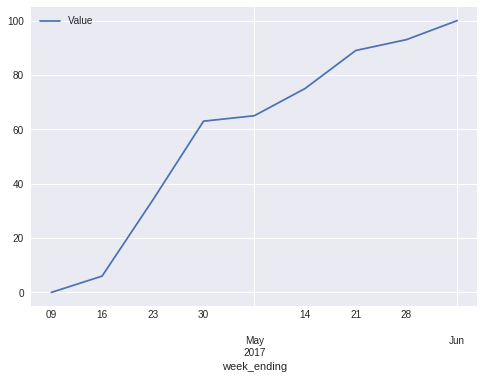

In [0]:
#visualize the progress 
df_2017.plot()

In [0]:
#resample so we now have daily data ('D'). should see a lot of NaN because still need to interpolate Value column
resampled_dfp = df_2017.resample('D')
resampled_dfp.head(20)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: 
.resample() is now a deferred operation
You called head(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  


,Value
week_ending,
2017-04-09,1.0
2017-04-10,NaN
2017-04-11,NaN
2017-04-12,NaN
2017-04-13,NaN
2017-04-14,NaN
2017-04-15,NaN
2017-04-16,6.0
2017-04-17,NaN


In [0]:
#use linear interpolation to get daily Values
interpolated = resampled_dfp.interpolate(method = 'linear')
print(interpolated.head(20))

                 Value
week_ending           
2017-04-09    1.000000
2017-04-10    1.714286
2017-04-11    2.428571
2017-04-12    3.142857
2017-04-13    3.857143
2017-04-14    4.571429
2017-04-15    5.285714
2017-04-16    6.000000
2017-04-17   10.000000
2017-04-18   14.000000
2017-04-19   18.000000
2017-04-20   22.000000
2017-04-21   26.000000
2017-04-22   30.000000
2017-04-23   34.000000
2017-04-24   38.142857
2017-04-25   42.285714
2017-04-26   46.428571
2017-04-27   50.571429
2017-04-28   54.714286


In [0]:
#Now we need to figure out how to do this for EVERY YEAR in a specific phase in Illinois

In [0]:
#use the saved csv
df = pd.read_csv('progress_data_raw.csv')

#select state and phase
df = df[df.state_name == 'ILLINOIS']
pl = df['unit_desc'] == 'PCT PLANTED'
dfp = df[['week_ending','Value']][pl]

#convert week_ending column to datetime format. set year to index.
dfp.week_ending = pd.to_datetime(dfp.week_ending, format = '%Y-%m-%d')
dfp.set_index('week_ending', inplace = True)

#find all the unique years
yrs = list(dfp.index.year.unique())

df_all = pd.DataFrame()
for y in yrs:
  df_year = dfp.loc[str(y)]
  df_year.iloc[0,0] = 0
  df_year.iloc[-1] = 100
  
  resampled_dfp = df_year.resample('D')
  interpolated_dfp = resampled_dfp.interpolate(method = 'linear')
  
  df_all = pd.concat([df_all, interpolated_dfp], axis = 0)

In [0]:
#Now we need to figure out how to do this for every year in EVERY PHASE in Illinois

In [121]:
#use the saved csv
df = pd.read_csv('progress_data_raw.csv')
df = df[df.state_name == 'ILLINOIS']

#list all the phases
phase = ['PCT PLANTED', 'PCT SILKING', 'PCT DOUGH','PCT DENTED', 'PCT MATURE'] #removed PCT HARVESTED b/c duplicate dates

df_all_phases_all_years = pd.DataFrame()

for p in phase:
  pl = df['unit_desc'] == p
  dfp = df[['week_ending','Value']][pl]
  
  dfp.week_ending = pd.to_datetime(dfp.week_ending, format = '%Y-%m-%d')
  dfp.set_index('week_ending', inplace = True)
  
  yrs = list(dfp.index.year.unique())
  
  df_specific_phase_all_years = pd.DataFrame() #prime the empty dataframe to collect specific phase data for every year
  
  for y in yrs:
    df_year = dfp.loc[str(y)]
    df_year.iloc[0,0] = 0
    df_year.iloc[-1,0] = 100
  
    resampled_dfp = df_year.resample('D')
    interpolated_dfp = resampled_dfp.interpolate(method = 'linear')
  
    df_specific_phase_all_years = pd.concat([df_specific_phase_all_years, interpolated_dfp], axis = 0)
    
  df_all_phases_all_years = pd.concat([df_all_phases_all_years, df_specific_phase_all_years], axis = 1)
  
  print(p)
  
df_all_phases_all_years.columns = ['PCT PLANTED', 'PCT SILKING', 'PCT DOUGH', 'PCT DENTED', 'PCT MATURE'] #still missing harvested

PCT PLANTED
PCT SILKING
PCT DOUGH
PCT DENTED
PCT MATURE


In [123]:
#should see a lot of NaN b/c not all phases have data for the same dates
df_all_phases_all_years.head()

,PCT PLANTED,PCT SILKING,PCT DOUGH,PCT DENTED,PCT MATURE
week_ending,,,,,
1979-04-29,0.000000,NaN,NaN,NaN,NaN
1979-04-30,0.571429,NaN,NaN,NaN,NaN
1979-05-01,1.142857,NaN,NaN,NaN,NaN
1979-05-02,1.714286,NaN,NaN,NaN,NaN
1979-05-03,2.285714,NaN,NaN,NaN,NaN


In [0]:
#Next step is to do this for every year in every phase in EVERY STATE